##Importing Libraries


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
import albumentations as A

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


##Loading Data

In [2]:
import zipfile

# Path to the uploaded zip file
zip_path = '/content/training.zip'

# Extract to /content/training
extract_path = '/content/training'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Extracted to {extract_path}")

Extracted to /content/training


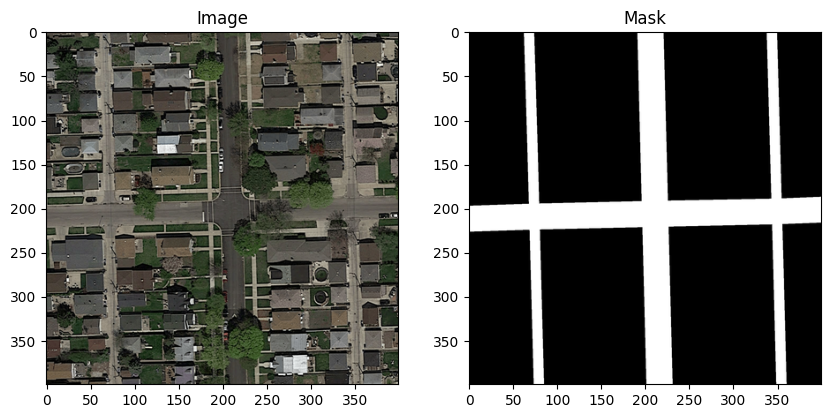

In [3]:
# Path to the images and groundtruth directories
image_dir = '/content/training/training/images'
mask_dir = '/content/training/training/groundtruth'

# List image files
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

# Function to load an image and its corresponding mask
def load_image_mask(image_file, mask_file):
    image_path = os.path.join(image_dir, image_file)
    mask_path = os.path.join(mask_dir, mask_file)

    # Read the image and the mask
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Assuming mask is grayscale

    return image, mask

# Load a sample image and mask
image, mask = load_image_mask(image_files[0], mask_files[0])

# Display the image and its corresponding mask
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')

plt.show()

##Data Augmentation

In [4]:
# Define the augmentation pipeline
augmentations = A.Compose([
    # Geometric transformations
    A.HorizontalFlip(p=1),
    A.VerticalFlip(p=0.8),
    A.RandomRotate90(p=0.9),
    A.Rotate(limit=45, p=0.7),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=0, p=1, border_mode=cv2.BORDER_CONSTANT),
    A.Affine(shear=(-20, 20), p=0.8),

    # Color manipulations
    A.RandomBrightnessContrast(p=1),
    A.HueSaturationValue(p=0.9),
    A.RGBShift(p=0.9),

    # Noise injection
    A.GaussNoise(p=0.9),
    A.ISONoise(p=0.9),

    # Blurring and sharpening
    A.MotionBlur(p=0.7),
    A.GaussianBlur(p=0.6),
    A.Sharpen(p=0.8),
    A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=1)
], additional_targets={'mask': 'mask'})  # Ensure mask undergoes the same spatial augmentations

# Define the output directories for saving augmented images and masks
output_images_dir = '/content/augmented_images/'
output_masks_dir = '/content/augmented_masks/'

# Create directories if they don't exist
os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_masks_dir, exist_ok=True)

# Lists to hold augmented images and masks
augmented_images = []
augmented_masks = []

# Loop through your dataset, apply augmentations, and save results
for i, (img_file, mask_file) in enumerate(zip(image_files, mask_files)):
    # Load image and mask
    img, mask = load_image_mask(img_file, mask_file)

    # Convert the grayscale mask to a pseudo-RGB format for augmentations
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

    # Apply augmentations
    augmented = augmentations(image=img, mask=mask_rgb)
    aug_image = augmented['image']
    aug_mask = augmented['mask']

    # Convert the augmented mask back to grayscale
    aug_mask = cv2.cvtColor(aug_mask, cv2.COLOR_RGB2GRAY)

    # Append augmented image and mask to the lists
    augmented_images.append(aug_image)
    augmented_masks.append(aug_mask)

    # Save the augmented image and mask to the respective folders
    image_path = os.path.join(output_images_dir, f"aug_image_{i}.png")
    mask_path = os.path.join(output_masks_dir, f"aug_mask_{i}.png")

    # Save images and masks as PNG files
    cv2.imwrite(image_path, aug_image)
    cv2.imwrite(mask_path, aug_mask)

# Convert lists to numpy arrays if needed for further processing
augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

# Print the shape of the augmented datasets
print("Augmented images shape:", augmented_images.shape)
print("Augmented masks shape:", augmented_masks.shape)

print("Augmented images and masks saved successfully!")


Augmented images shape: (100, 400, 400, 3)
Augmented masks shape: (100, 400, 400)
Augmented images and masks saved successfully!


In [5]:
augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

# Print the shape of the augmented datasets
print("Augmented images shape:", augmented_images.shape)
print("Augmented masks shape:", augmented_masks.shape)

Augmented images shape: (100, 400, 400, 3)
Augmented masks shape: (100, 400, 400)


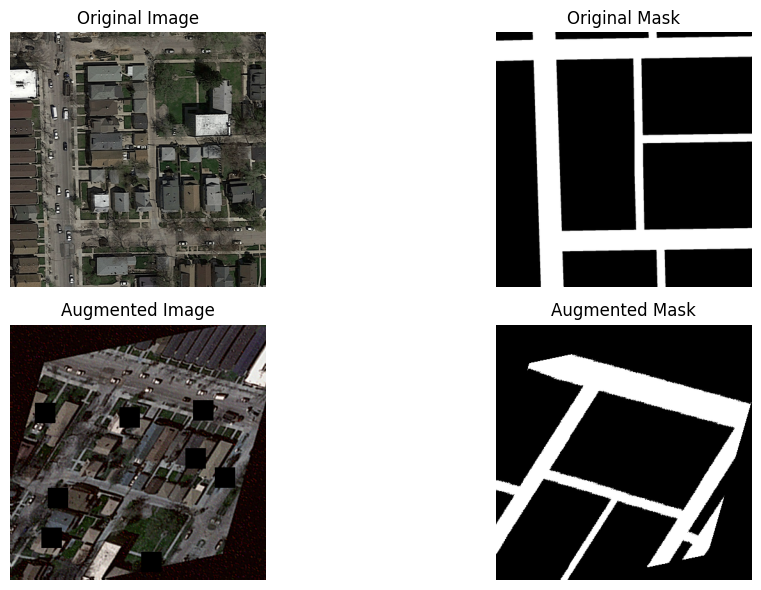

In [9]:
original_image, original_mask = load_image_mask(image_files[8], mask_files[8])
augmented_image =augmented_images[8]
augmented_mask = augmented_masks[8]

# Plot the original and augmented images and masks
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

# Original mask
plt.subplot(2, 2, 2)
plt.imshow(original_mask, cmap='gray')
plt.title("Original Mask")
plt.axis('off')

# Augmented and resized image
plt.subplot(2, 2, 3)
plt.imshow(augmented_image)
plt.title("Augmented Image")
plt.axis('off')

# Augmented and resized mask
plt.subplot(2, 2, 4)
plt.imshow(augmented_mask, cmap='gray')
plt.title("Augmented Mask")
plt.axis('off')

plt.tight_layout()
plt.show()